In [4]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы A, B, C, D отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [18]:
def find_period_length_fft(data: np.ndarray, **kwargs) -> float:
    """Вычисление длины периода в заданном веторе данных.

    Args:
        data (np.ndarray): Вектор данных.
        **kwargs: Дополнительные ключевые аргументы - параметры для метода Фурье.
                Подробнее можно прочитать на https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy-fft-fft

    Returns:
        float: Значение периода. Может получиться дробным.
    """

    # Применение прямого преобразования метода Фурье к данным
    yf = scipy.fft.fft(data, **kwargs)
    # Поиск индекса максимального значения в абсолютных величинах преобразованного вектора
    idx = np.argmax(np.abs(yf))
    # Нахождение длины периода, путем деления длины исходных данных на индекс максимального значения
    period = len(data)/idx
    return period

In [25]:
def get_mass_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 
 
        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

In [151]:
def get_frequences(coordinate_vector, data_length=256, skip_coefficient=3):
    fourier_transformed_vector = scipy.fft.fft(np.array(coordinate_vector)[:data_length]) / data_length
    sliced_fourier_transformed_vector = np.concatenate([np.zeros(skip_coefficient), fourier_transformed_vector[3: data_length // 2]])
    frequences = np.abs(sliced_fourier_transformed_vector)
    return frequences

In [168]:
def find_main_frequence_index(frequences, slice_percentage=1, data_length=256, normed=False):
    main_frequence = np.argmax(frequences[:int(slice_percentage * data_length)])
    if normed: main_frequence = main_frequence / data_length
    return main_frequence

In [10]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

In [20]:
data = read_data(r'bpm_data/11_01_booster_libera08_hbpm3_1_full', offset=offset, data_length=len_data)
data

,A,B,C,D
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


In [21]:
sx = data['A'] + data['C']
deltax = data['A'] - data['C']
sy = data['B'] + data['D']
deltay = data['B'] - data['D']

In [22]:
period = find_period_length_fft(sx)
period

2126.9290060851927

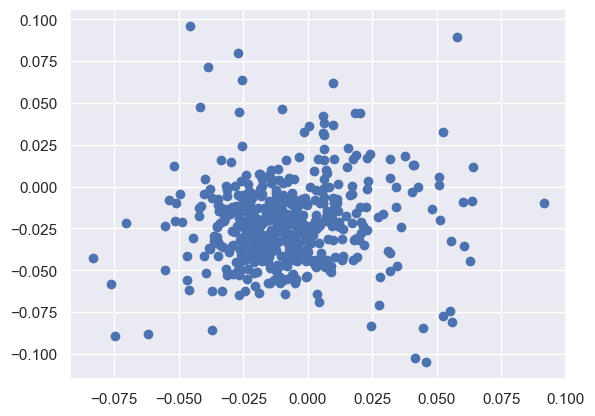

In [28]:
sns.set_theme()
x = get_mass_center_positions(sx, deltax, period)
y = get_mass_center_positions(sy, deltay, period)
plt.scatter(x, y)

In [164]:
A_x = 64
A_y = 33

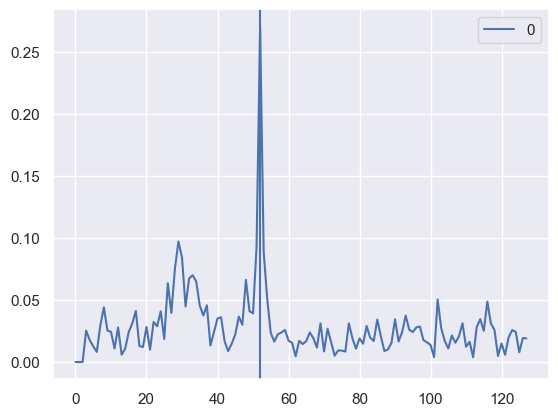

In [169]:
pd.DataFrame(f:=get_frequences(A_y * y)).plot()
plt.axvline(find_main_frequence_index(f))